# Mean Shift Tracking
Murphy Tian

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from shapely.geometry import box, Polygon

In [8]:
cap = cv2.VideoCapture("./KylianMbappe.mp4") # video

# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[1])
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))


# form histogram of hue in the roi
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

IOUs = []

while True:

    # grab a frame
    ret ,frame = cap.read()

    if ret == True:

        # convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # histogram back projection using roi_hist
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # display tracked window
        x,y,w,h = track_window
        img = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),5)

        face_boxes = face_detector.detectMultiScale(frame)
        (x1,y1,w1,h1) = tuple(face_boxes[0])
        truth_window = (x1,y1,w1,h1)

        img2 = cv2.rectangle(img, (x1,y1), (x1+w1,y1+h1), (0,255,0),5)

        cv2.imshow('cam shift tracking demo',img2)


        truth_bound = [[x, y], [x+w, y], [x+w, y+h], [x, y+h]]
        track_bound = [[x1, y1], [x1+w1, y1], [x1+w1, y1+h1], [x1, y1+h1]]

        polygon1_shape = Polygon(truth_bound)
        polygon2_shape = Polygon(track_bound)

        polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
        polygon_union = polygon1_shape.union(polygon2_shape).area
        IOU = polygon_intersection / polygon_union
        IOUs.append(IOU)


        if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break

    else:
        break

cv2.destroyAllWindows()
cap.release()


46 96
0.4791666666666667


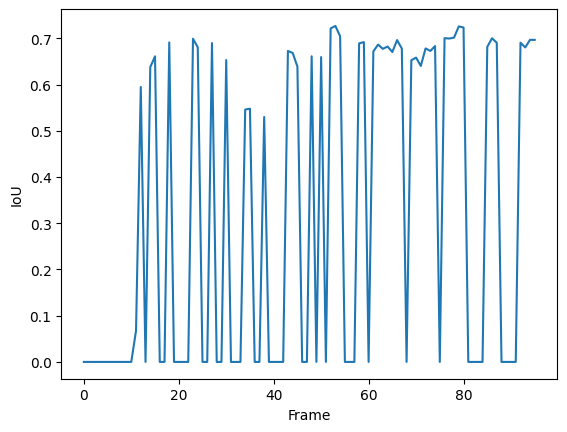

In [9]:
count = 0
for i in IOUs:
    if i > 0.5:
        count += 1
print(count, len(IOUs))
print(count / len(IOUs))
plt.plot(list(range(len(IOUs))), IOUs)
plt.xlabel('Frame')
plt.ylabel('IoU')
plt.show()

In [13]:
cap = cv2.VideoCapture("./KylianMbappe.mp4") # video

# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[1])
track_window = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue
roi_gray =  cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

roi_gray = cv2.GaussianBlur(roi_gray, (7,7), 5)


gradient_x = cv2.Sobel(roi_gray, cv2.CV_32F, 1, 0, ksize=5)
gradient_y = cv2.Sobel(roi_gray, cv2.CV_32F, 0, 1, ksize=5)
blurred_x = cv2.GaussianBlur(gradient_x, (7,7), 5)
blurred_y = cv2.GaussianBlur(gradient_y, (7,7), 5)

magnitude, angle = cv2.cartToPolar(blurred_x, blurred_y, angleInDegrees=True)

lower =  np.array((5.))
upper =  np.array((360.))
mask = cv2.inRange(magnitude, lower, upper)
# form histogram of hue in the roi
roi_hist = cv2.calcHist([roi_gray],[0],mask,[24],[0,360])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

IOUs = []

while True:

    # grab a frame
    ret ,frame = cap.read()

    if ret == True:

        # convert to HSV
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        gray_blur = cv2.GaussianBlur(gray, (7,7), 5)

        gradient_x = cv2.Sobel(gray_blur, cv2.CV_32F, 1, 0, ksize=5)
        gradient_y = cv2.Sobel(gray_blur, cv2.CV_32F, 0, 1, ksize=5)
        blurred_x = cv2.GaussianBlur(gradient_x, (7,7), 5)
        blurred_y = cv2.GaussianBlur(gradient_y, (7,7), 5)
        magnitude, angle = cv2.cartToPolar(blurred_x, blurred_y, angleInDegrees=True)
        dst = cv2.calcBackProject([angle],[0],roi_hist,[0,360],1)

        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # display tracked window
        x,y,w,h = track_window
        img = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 5)

        face_boxes = face_detector.detectMultiScale(frame)
        (x1,y1,w1,h1) = tuple(face_boxes[0])
        truth_window = (x1,y1,w1,h1)

        img2 = cv2.rectangle(img, (x1,y1), (x1+w1,y1+h1), (0,255,0),5)

        cv2.imshow('cam shift tracking demo',img2)



        truth_bound = [[x, y], [x+w, y], [x+w, y+h], [x, y+h]]
        track_bound = [[x1, y1], [x1+w1, y1], [x1+w1, y1+h1], [x1, y1+h1]]

        polygon1_shape = Polygon(truth_bound)
        polygon2_shape = Polygon(track_bound)

        polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
        polygon_union = polygon1_shape.union(polygon2_shape).area
        IOU = polygon_intersection / polygon_union
        IOUs.append(IOU)


        if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break

    else:
        break

cv2.destroyAllWindows()
cap.release()

0 96
0.0


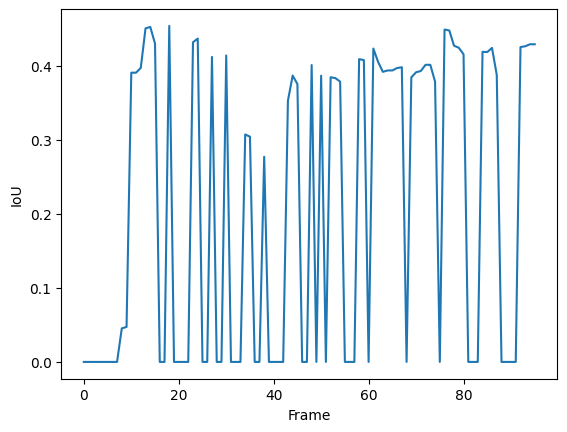

In [15]:
count = 0
for i in IOUs:
    if i > 0.5:
        count += 1
print(count, len(IOUs))
print(count / len(IOUs))
plt.plot(list(range(len(IOUs))), IOUs)
plt.xlabel('Frame')
plt.ylabel('IoU')
plt.show()
